In [1]:
!python3 --version

Python 3.5.2


# content

[1. Getting Started](#getting_started)

- [1.1 Preparing data set](#preparing_data_set)

- [1.2 Select and Plot image samples](#select_and_plot_image_samples)

[2. Template Matching](#template_matching)
   
- [2.1 Compare different matching algorithms](#compare_different_matching_algorithms)

- [2.2. Classifier and Validate the results](#classifier_and_validate_the_results)

[3. Perceptron](#perceptron)

[4. Classification Comparison](#classification_comparison)

[5. Feature Engineering](#Feature_engineering)

- [5.1 Feature Extraction](#feature_extraction)

- [5.2 Train on new data](#train_on_new_data)

- [5.3 Results and Conclusion](#results_and_conclusion)

<a id='getting_started'></a>

# 1. Getting Started

<a id='preparing_data_set'></a>

## 1.1 Preparing data sets

First of all, before showing some image samples, all images from all subsets are read and labeled into different data sets.

The general process of creating the data sets could be described as,
1. Get all image pathes from subset 1 to 10 as all training and validation set, get all images from subset 31 to subset 40 as test set;
2. Loop over each image to pair it with the rest of other images;
3. Find the subset name of each pair images. If two images have the same subset name, define them as the pair showing the same face;
4. Label the image pair $1$ for showing the same face, $0$ for showing different faces;
5. Save the data set as format: '[str(image_path_one), str(image_path_two), int(label)]'
6. Separate each data set to the same face set and different faces set;
7. Create the training set and validation set from sub1to10, which have same portion of image pairs showing same face;
8. Print out sizes of all the sets for visualization.

In [2]:
import re
import os
import random
import numpy as np
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt

# define all the sub names, session names, and frame names into np.array
sub_names_train = np.arange(1, 11)
sub_names_test = np.concatenate([np.arange(31, 39), np.array([40])], axis = -1)
session_names = np.arange(1, 3)
frame_names_train = np.arange(1, 24)
frame_names_test = np.arange(1, 25)

def ReadImage(image_path):
    """
    Function:
        Read and resize images with specific subname, session name and frame name.
    """
    # read the image
    image = imread(image_path)
    # resize the image
    output_size = (64, 64)
    image = resize(image, output_size)
    return image

def GetImageWithSubName(sub, sess, frame):
    """
    Function: 
        Get image path name according to the inputs.
    """
    # read the image path
    folder_name = "sub" + str(sub) + "_session" + str(sess)
    image_path = folder_name + "/" + folder_name + "_frame" + str(frame) + ".png"
    image = ReadImage(image_path)
    sub_name = sub
    return image, sub_name

def GetAllData(sub_names, session_names, frame_names):
    """
    Function:
        Read all images in the dataset with their subset names.
    """
    # subset 35 and subset 37 have no session 2
    sub_no_sess2_test = np.array([35, 37])
    # store pathes
    all_imgs= []
    all_subs = []
    for i in range(len(sub_names)):
        sub = sub_names[i]
        if sub in sub_no_sess2_test:
            sess_len = len(session_names) - 1
        else:
            sess_len = len(session_names)
        for j in range(sess_len):
            sess = session_names[j]
            for k in range(len(frame_names)):
                frame = frame_names[k]
                image, image_sub = GetImageWithSubName(sub, sess, frame)
                all_imgs.append(image)
                all_subs.append(image_sub)
    all_imgs = np.array(all_imgs)
    all_subs = np.array(all_subs)
    return all_imgs, all_subs

def PairWithIndex(all_subs):
    """
    Function:
        Pair each two images with the image indexes, then define labels.
    """
    imgs_ind = np.arange(len(all_subs))
    all_pairs = []
    # loop over each image with the rest images
    while len(imgs_ind) > 0:
        current_img_ind = imgs_ind[0]
        imgs_ind = np.delete(imgs_ind, 0)
        for another_img_ind in imgs_ind:
            if all_subs[current_img_ind] == all_subs[another_img_ind]:
                label = 1
            else:
                label = 0
            all_pairs.append([current_img_ind, another_img_ind, label])
    all_pairs = np.array(all_pairs)
    return all_pairs

def TrainValidSep(all_pairs, validation_rate = 0.01):
    """
    Function:
        Separate the dataset for training into train set and validation set.
    """
    same_pairs = all_pairs[all_pairs[:, 2] == 1]
    diff_pairs = all_pairs[all_pairs[:, 2] == 0]
    # shuffle two sets first
    np.random.shuffle(same_pairs)
    np.random.shuffle(diff_pairs)
    #############################################################
#     diff_pairs = diff_pairs[:3 * len(same_pairs)]
    valid_same_len = int(validation_rate * len(same_pairs))
    valid_diff_len = int(validation_rate * len(diff_pairs))
    valid_set = np.concatenate([same_pairs[:valid_same_len,:],\
                               diff_pairs[:valid_diff_len,:]], axis = 0)
#     train_set = np.concatenate([same_pairs[valid_same_len:,:],\
#                                diff_pairs[valid_diff_len:,:]], axis = 0)
    train_set = np.concatenate([same_pairs[valid_same_len:,:],\
                               diff_pairs[valid_diff_len: valid_diff_len+5*len(same_pairs[valid_same_len:,:]),:]], axis = 0)
    # shuffle again for creating the final sets
    np.random.shuffle(train_set)
    np.random.shuffle(valid_set)
    return train_set, valid_set

def SameDiffSep(all_pairs):
    """
    Function:
        Seperate the current set into same face set and different face set.
    """
    same_pairs = all_pairs[all_pairs[:, 2] == 1]
    diff_pairs = all_pairs[all_pairs[:, 2] == 0]
    return same_pairs, diff_pairs
    
# get all images and corresponding subset names
train_images, train_subnames = GetAllData(sub_names_train, session_names, frame_names_train)

test_images, test_subnames = GetAllData(sub_names_test, session_names, frame_names_test)

# get all image pairs using index representation
all_train_pairs = PairWithIndex(train_subnames)
all_test_pairs = PairWithIndex(test_subnames)
# shuffle dataset
np.random.shuffle(all_test_pairs)
# get same and diff set of the sets for further usage
train_same_ind, train_diff_ind = SameDiffSep(all_train_pairs)
test_same_ind, test_diff_ind = SameDiffSep(all_test_pairs)
# separate the set into training set and validation set
train_ind, valid_ind =TrainValidSep(all_train_pairs)

print("-------------------------- dataset used for training and validation ----------------------")
print("The orginal set conatains totally \t", len(all_train_pairs), "\t pairs of images, \nwith \t\t\t\t\t", \
      len(train_same_ind), "\t\t pairs showing same faces \nand \t\t\t\t\t", \
      len(train_diff_ind), "\t\t pairs showing different faces.")

print("---------------------------------- dataset used for test ---------------------------------")
print("The test set conatains totally \t\t", len(all_test_pairs), "\t\t pairs of images, \nwith \t\t\t\t\t", \
      len(test_same_ind), "\t\t pairs showing same faces \nand \t\t\t\t\t", \
      len(test_diff_ind), "\t\t pairs showing different faces.")

print("----------------------------- training set and validation set ----------------------------")
print("After separation, the training set contains \t", len(train_ind), "\t pairs of images,\
        \nand validation set contrains \t\t\t", len(valid_ind), "\t\t pairs of images.")


-------------------------- dataset used for training and validation ----------------------
The orginal set conatains totally 	 105570 	 pairs of images, 
with 					 10350 		 pairs showing same faces 
and 					 95220 		 pairs showing different faces.
---------------------------------- dataset used for test ---------------------------------
The test set conatains totally 		 73536 		 pairs of images, 
with 					 8448 		 pairs showing same faces 
and 					 65088 		 pairs showing different faces.
----------------------------- training set and validation set ----------------------------
After separation, the training set contains 	 61482 	 pairs of images,        
and validation set contrains 			 1055 		 pairs of images.


<a id='select_and_plot_image_samples'></a>

## 1.2 Select and Plot image samples

In order to visualize what the data set looks like, a set of image samples are selected and plotted. The first row of images showing the same face but with different illuminations. The second row shows different faces with different illuminations.

Also, all these image samples are used to find out the Nomalized Cross-Correlation threshold in the following session.

Image shape is: 	 (64, 64, 3)


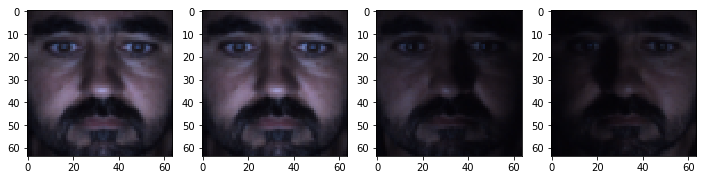

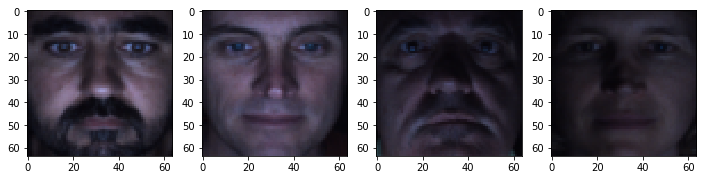

In [3]:
# image examples, for visualization and some tests
# same faces
image_example_1, _ = GetImageWithSubName(sub_names_train[0], session_names[0], frame_names_train[0])
image_example_2, _ = GetImageWithSubName(sub_names_train[0], session_names[1], frame_names_train[0])
image_example_3, _ = GetImageWithSubName(sub_names_train[0], session_names[0], frame_names_train[10])
image_example_4, _ = GetImageWithSubName(sub_names_train[0], session_names[0], frame_names_train[22])
# different faces
image_example_5, _ = GetImageWithSubName(sub_names_train[1], session_names[0], frame_names_train[0])
image_example_6, _ = GetImageWithSubName(sub_names_train[5], session_names[0], frame_names_train[5])
image_example_7, _ = GetImageWithSubName(sub_names_test[5], session_names[0], frame_names_test[22])

# print out the shape of the image
print("Image shape is: \t", image_example_1.shape)

# same faces test
fig = plt.figure(figsize = (12, 3))
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)
ax1.imshow(image_example_1)
ax2.imshow(image_example_2)
ax3.imshow(image_example_3)
ax4.imshow(image_example_4)
plt.show()

# different faces test
fig = plt.figure(figsize = (12, 3))
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)
ax1.imshow(image_example_1)
ax2.imshow(image_example_5)
ax3.imshow(image_example_6)
ax4.imshow(image_example_7)
plt.show()

<a id='template_matching'></a>

# 2. Template Matching

<a id='compare_different_matching_algorithms'></a>

## 2.1 Compare different matching algorithms

In order to find the best template matching method, I developed several matching functions which were introduced in the lecture, namely cross-correlation(normalized), cross-correlation, convolution, and SSD. Then all image samples shown above are fed into those classifiers seperately and the corresponding scores are printed out at the end of the cell.

The results of all template matching skills are printed out at the end of the cell. Apparently, only NCC shows the ability to classify the same face pair and different faces pair. Therefore, in this assignment, the classifier will be built based on Normalized Cross-Correlation. And the corresponding **threshold is set $0.6$**.

In [4]:

def NormalizedCrossCorrelation(image1, image2):
    """
    Funtion: calculating normalized cross correlation (NCC) between two images
    """
    numerator = np.sum((image1 - np.mean(image1)) * (image2 - np.mean(image2)))
    denominator = np.sqrt(np.sum(np.square(image1 - np.mean(image1))) * \
                          np.sum(np.square(image2 - np.mean(image2))))
    return numerator / denominator

def Convolution(image1, image2):
    """
    Funtion: calculating convolution between two images
    """
    return np.sum(np.flip((image1 - image1.mean())) * image2)

def SumSquareDifferences(image1, image2):
    """
    Funtion: calculating pixel differences between two images
    """
    return np.sum(np.square(image1 - image2))

def CompareAllTricks(image1, image2):
    """
    Function: compare the scores w.r.t 3 methods and choose the best one
    """
    a = NormalizedCrossCorrelation(image1, image2)
    b = Convolution(image1, image2)
    c = SumSquareDifferences(image1, image2)
    return [a, b, c]

# try differences betwwen correlation, convolution and squared differences
# try with same faces but different illumination
compare_example_1 = CompareAllTricks(image_example_1, image_example_2)
compare_example_2 = CompareAllTricks(image_example_1, image_example_3)
compare_example_3 = CompareAllTricks(image_example_1, image_example_4)
# try with different faces with different illumination
compare_example_4 = CompareAllTricks(image_example_1, image_example_5)
compare_example_5 = CompareAllTricks(image_example_1, image_example_6)
compare_example_6 = CompareAllTricks(image_example_1, image_example_7)

print("---------------------------------- same faces ------------------------------------")
print("NCC:{} \t \t \t Conv:{} \t SSD:{}".format(compare_example_1[0], compare_example_1[1], compare_example_1[2]))
print("NCC:{} \t \t Conv:{} \t SSD:{}".format(compare_example_2[0], compare_example_2[1], compare_example_2[2]))
print("NCC:{} \t \t Conv:{} \t SSD:{}".format(compare_example_3[0], compare_example_3[1], compare_example_3[2]))
print("------------------------------- different faces ----------------------------------")
print("NCC:{} \t \t Conv:{} \t SSD:{}".format(compare_example_4[0], compare_example_4[1], compare_example_4[2]))
print("NCC:{} \t \t Conv:{} \t SSD:{}".format(compare_example_5[0], compare_example_5[1], compare_example_5[2]))
print("NCC:{} \t Conv:{} \t SSD:{}".format(compare_example_6[0], compare_example_6[1], compare_example_6[2]))


---------------------------------- same faces ------------------------------------
NCC:1.0 	 	 	 Conv:84.91780926074851 	 SSD:0.0
NCC:0.7177882918040279 	 	 Conv:34.39739781668252 	 SSD:266.91643021914643
NCC:0.6618261099181423 	 	 Conv:27.32804301155204 	 SSD:294.1769127258746
------------------------------- different faces ----------------------------------
NCC:0.5338608734949605 	 	 Conv:60.85439800187653 	 SSD:163.69754036908876
NCC:0.2861959200424425 	 	 Conv:17.488654840536064 	 SSD:252.9331487889273
NCC:0.38768792843956684 	 Conv:20.040709458482795 	 SSD:236.74956843521716


Here, since we got only limited number of validation set image pair, therefore, we first get all the input data and output labels of the validation set for the preparation.

In [5]:

def GetInputOutput(images, set_ind):
    """
    Function:
        Get training inputs and labels.
    """
    all_inputs = []
    all_outputs = []
    for i in range(len(set_ind)):
        pair = set_ind[i]
        img_pair = np.concatenate([images[pair[0]], \
                                   images[pair[1]]], axis = 0)
        img_pair = np.reshape(img_pair, (-1))
        label = float(pair[2])
        all_inputs.append(img_pair)
        all_outputs.append(label)
    all_inputs = np.array(all_inputs)
    all_outputs = np.array(all_outputs)
    return all_inputs, all_outputs

# get all the concatenated images and labels of validation set
valid_inputs, valid_outputs = GetInputOutput(train_images, valid_ind)

print("The input shape of the validation set is: \t", valid_inputs.shape)
print("The label shape of the validation set is: \t", valid_outputs.shape)


The input shape of the validation set is: 	 (1055, 24576)
The label shape of the validation set is: 	 (1055,)


<a id='classifier_and_validate_the_results'></a>

## 2.2 Classifier and Validate the results

First, since the validation set is relatively small when compared to other data sets, all the images of the set are read and then saved into RAM with the labels.

A classifier is built based on NCC with threshold $0.6$.

All image pairs in the validation set are then sent into the classifier and the predictions are compared with the ground truth labels to give the accuracy result. Also, a timer is set during the whole prediction process in order to find out how much time it costs. All results are printed out at the end of the cell.

Clearly, the accuracy of the current classifier is about $75$%. It is moderately reasonable because only one image processing skill is applied onto the classifier.

Random results of same face pair prediction and different faces pair prediction with corresponding images are plotted.

----------------------------- validation results ----------------------------------
The accuracy of NCC classifier on the validation is: 		 0.8189573


------------------------- random prediction samples -------------------------------
label of this pair is: 	 same face


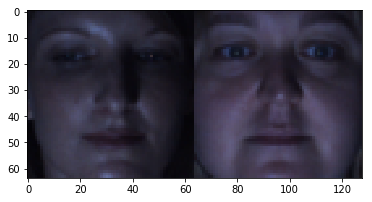

label of this pair is: 	 different faces


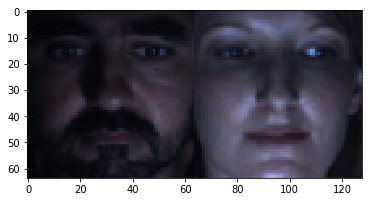

In [6]:

def NCCClassifier(img1, img2, NCC_threshold = 0.6):
    """
    Function:
        Build a classifier to tell whether two images are showing the same
    face or not.
    """
    score = NormalizedCrossCorrelation(img1, img2)
    if score >= NCC_threshold:
        pred = 1
    else:
        pred = 0
    return pred

def AccuracyCalculation(pred, label):
    """
    Function:
        Find out the accuracy reasults on the validation set
    """
    results_masks = np.equal(pred, label).astype(np.float32)
    accuracy = np.mean(results_masks)
    return accuracy

def NCCClassifierOnSet(img_concats, NCC_threshold):
    """
    Function:
        Get the accuracy results on the whole set.
    """
    all_prediction = []
    for i in range(len(img_concats)):
        current_img_concat = img_concats[i]
        current_img_concat = np.reshape(current_img_concat, (128, 64, -1))
        w = current_img_concat.shape[0] // 2
        current_img_1 = current_img_concat[:w, ...]
        current_img_2 = current_img_concat[w:, ...]
        current_pred = NCCClassifier(current_img_1, current_img_2, NCC_threshold)
        all_prediction.append(current_pred)
    all_prediction = np.array(all_prediction)
    return all_prediction

def ShowRandomPair(img_concats, preds, sample_same_face = True):
    """
    Function:
        Show random pairs of the NCC classifier prediction to visualize the result.
    """
    if sample_same_face:
        target = 1
        label_show = "same face"
    else:
        target = 0
        label_show = "different faces"
    imgs_select = img_concats[preds == target]
    random_ind = np.random.randint(len(imgs_select))
    imgs = imgs_select[random_ind]
    imgs = np.reshape(imgs, (128, 64, -1))
    w = imgs.shape[0] // 2
    img1 = imgs[:w, ...]
    img2 = imgs[w:, ...]
    display_imgs = np.concatenate([img1, img2], axis = 1)
    print("label of this pair is: \t", label_show)
    plt.imshow(display_imgs)
    plt.show()

# setting threshold for same faces
NCC_threshold = 0.65
# get the predictions of NCC classifier
classifier_predictions = NCCClassifierOnSet(valid_inputs, NCC_threshold)
# get the accuracy on the validation set
classifier_validation_accuracy = AccuracyCalculation(classifier_predictions, valid_outputs)

print("----------------------------- validation results ----------------------------------")
print("The accuracy of NCC classifier on the validation is: \t\t", classifier_validation_accuracy)

print("\n")
print("------------------------- random prediction samples -------------------------------")
ShowRandomPair(valid_inputs, classifier_predictions, True)
ShowRandomPair(valid_inputs, classifier_predictions, False)


<a id='perceptron'></a>

# 3. Perceptron

First, the reason why there is a input generator is because the size of the training data set is too big. It has more than $10,000$ images which makes it impossible to read all images and store them into RAM once and for all. Therefore, a data generator is built for better memory orgnization.

Second, the MLP model structure in this assignmen can be described as,

    [batch, 128 * 64 * 3] -> [batch, 1024] -> [batch, 256] -> [batch, 64] -> [batch, 1]

Other parameters are set as:

- activation function of hidden layers: "relu";
- gating function: "sigmoid";
- loss function: "binary cross entropy";
- optimizer: "Adam";
- batch size: $256$;
- epoches: $2$ (because the training process is really slow);

The loss value and validation accuracy are checked at each batch. And finally, all check points are saved into numpy array for further usage.

In [10]:
##### set specific gpu #####
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
##### start other dependencies #####
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization, Dropout
from keras import regularizers
from keras.optimizers import Adam, SGD
from keras import backend as K

K.clear_session()

# def GetTrainData(train_images, train_current_ind):

def MLPModel():
    """
    Building the MLP model
    """
    model = Sequential()
    # structure: (batch, 128*64*3) -> (batch, 256) -> (batch, 64) -> (batch, 1)
    model.add(Dense(units = 256, input_shape = (128 * 64 * 3,), activation='relu',\
                   kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(units = 128, activation='relu', kernel_regularizer=regularizers.l2(0.01), \
                    bias_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(units = 64, activation='relu', kernel_regularizer=regularizers.l2(0.01), \
                    bias_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(units = 16, activation='relu', kernel_regularizer=regularizers.l2(0.01), \
                    bias_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1, activation = "sigmoid"))
    # using cross entropy as loss and adam as optimizer
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=0.001, decay=1e-1),
                  metrics=['accuracy'])
    return model

# define model.fit_generator parameters.
batch_size = 512
num_batch_train = len(train_ind) // batch_size

# gpu memory
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

# get model
model = MLPModel()

# training and validating on each batch
epoches = 12
train_loss = []
valid_acc = []
for each_epoch in range(epoches):
    for each_batch in range(num_batch_train):
        train_batch_id = train_ind[each_batch*batch_size: (each_batch+1)*batch_size]
        train_batch, label_batch = GetInputOutput(train_images, train_batch_id)
        train_los_metr =  model.train_on_batch(train_batch, label_batch)
        val_los_metr = model.evaluate(valid_inputs, valid_outputs, verbose=0)
        train_loss.append(train_los_metr[0])
        valid_acc.append(val_los_metr[1])
        print("current epoch: {}/{}, current_batch: {}/{}, train_loss: {}, valid_acc: {}"\
              .format(each_epoch, epoches, each_batch, num_batch_train, train_los_metr[0], \
                      val_los_metr[1]), end = "\r")

    

In order to visualize the learning effort, all saved checked points are called and the corresponding loss value and validation accuracy are plotted out at the end of the cell.

Apparently, the loss value goes down extremely fast at the very bignning before it slows down its convergence speed. At the end of the training, the validation accuracy reaches over $95$%, which is relatively higher than the NCC classifier.

The accuracy of MLP on the validation is: 	 0.9734597156398104


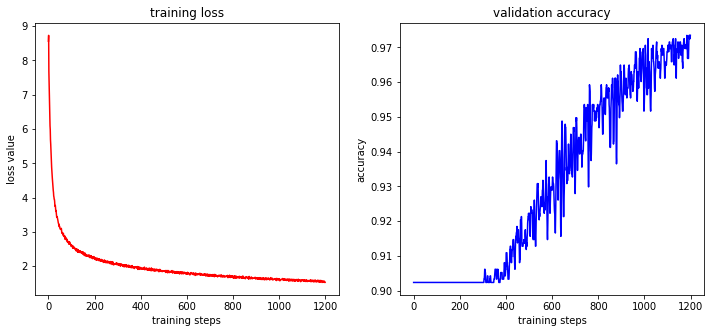

In [11]:

print("The accuracy of MLP on the validation is: \t", valid_acc[-1])

display_steps = int(1 * len(train_loss))

fig = plt.figure(figsize = (12, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(train_loss[:display_steps], 'r')
ax1.set_title("training loss")
ax1.set_xlabel("training steps")
ax1.set_ylabel("loss value")
ax2.plot(valid_acc[:display_steps], 'b')
ax2.set_title("validation accuracy")
ax2.set_xlabel("training steps")
ax2.set_ylabel("accuracy")
plt.show()


<a id='classification_comparison'></a>

# 4. Classification Comparison

The NCC classifier and the MLP are tested seprately on the test set, which consists of the data from subset 31 to 40. All results are printed out at the end of the cell.

A brief conclusion could be drawn as below,
1. NCC classifier shows a prosiming results on the image pairs showing the same face. Although, MLP performances well on this set, but the result is lower than the NCC classifier. The reason is because of the unbalanced dataset portion. Since test set itself has totally $73536$ image pairs with only $8448$ paris showing the same face, there lacks enough information about same faces for the model to learn.
2. This immediately verifies the reason above. Since there are enough image pairs for MLP to learn different faces, the MLP extremely outperforms the NCC classifier for the different faces.
3. Overall, the performance for the MLP is better than the NCC classifier.
4. For the prediction speed, it is highly related to the model complexity.

Other comparisons are concluded as below,
1. The training effort of NCC classifier involves much human work, but within several samples, the classifier could be set down with relatively good prediction results. On the contrary, although there is no human labour involved in the MLP, it requires huge dataset for the model to give the right predicitons.
2. For robustness, I think, with enough data, MLP could be more reliable and stable than the NCC classifier.
3. For generalization, since in the real world, enough data sets are not always the case, people normally tend to combine different traiditional processing skills to derive the dataset. Therefore, no matter it is NCC classifier or MLP, they should be used in the right places when consider different situations.

In [12]:
import time

def NCCTestOnBatch(test_imgs, test_ind, batch_size):
    """
    Function:
        Evaluate the NCC classifier on the test set.
    """
    batch_count = 0
    total_batch = len(test_ind) // batch_size
    total_time = []
    all_acc = []
    for batch_id in range(total_batch):
        test_batch_id = test_ind[batch_id*batch_size: (batch_id+1)*batch_size]
        test_batch, label_batch = GetInputOutput(test_imgs, test_batch_id)
        start_time = time.time()
        current_predictions = NCCClassifierOnSet(test_batch, NCC_threshold)
        current_validation_accuracy = AccuracyCalculation(current_predictions, label_batch)
        time_duration = time.time() - start_time
        print("current batch: {}/{}, test batch result: {}".format(batch_count, total_batch, \
                                                                   current_validation_accuracy), end="\r")
        all_acc.append(current_validation_accuracy)
        total_time.append(time_duration)
        batch_count += 1
    print("---------------------- test results ---------------------------")
    average_time = np.mean(total_time)
    average_acc = np.mean(all_acc)
    return average_acc, average_time

def MLPTestOnBatch(test_imgs, test_ind, mlp_model, batch_size):
    """
    Function:
        Evaluate the MLP model on the test set.
    """
    batch_count = 0
    total_batch = len(test_ind) // batch_size
    total_time = []
    all_acc = []
    for batch_id in range(total_batch):
        test_batch_id = test_ind[batch_id*batch_size: (batch_id+1)*batch_size]
        test_batch, label_batch = GetInputOutput(test_imgs, test_batch_id)
        start_time = time.time()
        test_result = mlp_model.evaluate(test_batch, label_batch, verbose = 0)
        print("current batch: {}/{}, test batch result: {}".format(batch_count, total_batch, \
                                                                   test_result), end="\r")
        time_duration = (time.time() - start_time)
        total_time.append(time_duration)
        all_acc.append(test_result[1])
        batch_count += 1
    print("----------------------------- fresh results -------------------------------")
    average_time = np.mean(total_time)
    final_results = np.mean(all_acc)
    return final_results, average_time

print("\n")
NCC_acc_same, NCC_time_same = NCCTestOnBatch(test_images, test_same_ind, batch_size)
print("Accuracy of NCC classifier on the same face data:\t", NCC_acc_same, \
      "\nwith average prediction time:\t\t\t\t", NCC_time_same)
NCC_acc_diff, NCC_time_diff = NCCTestOnBatch(test_images, test_diff_ind, batch_size)
print("Accuracy of NCC classifier on the different face data:\t", NCC_acc_diff, \
      "\nwith average prediction time:\t\t\t\t", NCC_time_diff)
NCC_acc_all, NCC_time_all = NCCTestOnBatch(test_images, all_test_pairs, batch_size)
print("Accuracy of NCC classifier on the all data:\t", NCC_acc_all, \
      "\nwith average prediction time:\t\t\t\t", NCC_time_all)

print("\n")
MLP_acc_same, MLP_time_same = MLPTestOnBatch(test_images, test_same_ind, model, batch_size)
print("Accuracy of MLP on the same face data:\t", MLP_acc_same, \
      "\nwith average prediction time:\t\t\t\t", MLP_time_same)
MLP_acc_diff, MLP_time_diff = MLPTestOnBatch(test_images, test_diff_ind, model, batch_size)
print("Accuracy of MLP on the different face data:\t", MLP_acc_diff, \
      "\nwith average prediction time:\t\t\t\t", MLP_time_diff)
MLP_acc_all, MLP_time_all = MLPTestOnBatch(test_images, all_test_pairs, model, batch_size)
print("Accuracy of MLP on the all data:\t", MLP_acc_all, \
      "\nwith average prediction time:\t\t\t\t", MLP_time_all)




---------------------- test results ---------------------------
Accuracy of NCC classifier on the same face data:	 0.90734863 
with average prediction time:				 0.08140033483505249
---------------------- test results ---------------------------
Accuracy of NCC classifier on the different face data:	 0.6693836 
with average prediction time:				 0.07356421966252365
---------------------- test results ---------------------------
Accuracy of NCC classifier on the all data:	 0.6965554 
with average prediction time:				 0.06954542573515352


----------------------------- fresh results -------------------------------
Accuracy of MLP on the same face data:	 0.732177734375 
with average prediction time:				 0.19575093686580658
----------------------------- fresh results -------------------------------]
Accuracy of MLP on the different face data:	 0.8239573080708661 
with average prediction time:				 0.19966760019617757
----------------------------- fresh results ------------------------------

<a id='Feature_engineering'></a>

# 5. Feature Engineering

<a id='feature_extraction'></a>

## 5.1 Feature Extraction

First of all, since all box filters technically belong to the cross-correlation familes, featire extraction kernels, such as Sober, Prewitt, and Robert are also special cross-correlations.

Several processing skills have been tried in this assignment, and finally the pre-process is settled as,
1. Grayscale the image.
2. Apply histogram equalization on the image to emphasize the contrast.
3. Use Sobel kernel to extract the gradient of the image.

With all the steps described above, the outline of the face is finally extracted out. Same image samples which were used in the first section are used again for the comparison. Images are plotted at the end of the cell.

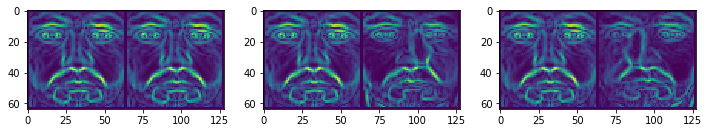

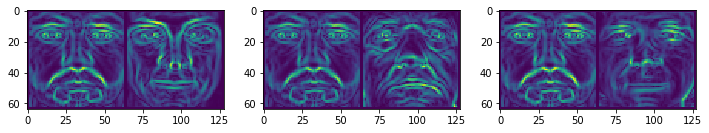

In [13]:
from skimage.color import rgb2gray
from skimage.exposure import equalize_hist
from skimage.filters import roberts, sobel

def GrayGradient(img):
    """
    Function: 
        Find the gradient of the image after grayscaled
    """
    gray_img = rgb2gray(img)
    return sobel(gray_img)

def GrayHistSobel(img):
    """
    Function:
        Apply histogram equalization on the grayscaled image first,
    then find the gradient.
    """
    gray_img = rgb2gray(img)
    gray_hist = equalize_hist(gray_img)
    return sobel(gray_hist)

# try image processing skills on all the example images
image_processsample_1 = GrayHistSobel(image_example_1)
image_processsample_2 = GrayHistSobel(image_example_2)
image_processsample_3 = GrayHistSobel(image_example_3)
image_processsample_4 = GrayHistSobel(image_example_4)
image_processsample_5 = GrayHistSobel(image_example_5)
image_processsample_6 = GrayHistSobel(image_example_6)
image_processsample_7 = GrayHistSobel(image_example_7)

# try with same faces but different illumination
sample1 = np.concatenate([image_processsample_1, image_processsample_2], axis = 1)
sample2 = np.concatenate([image_processsample_1, image_processsample_3], axis = 1)
sample3 = np.concatenate([image_processsample_1, image_processsample_4], axis = 1)
# try with different faces with different illumination
sample4 = np.concatenate([image_processsample_1, image_processsample_5], axis = 1)
sample5 = np.concatenate([image_processsample_1, image_processsample_6], axis = 1)
sample6 = np.concatenate([image_processsample_1, image_processsample_7], axis = 1)


# show results of the same faces
fig = plt.figure(figsize = (12, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.imshow(sample1)
ax2.imshow(sample2)
ax3.imshow(sample3)
plt.show()

# show results of different faces
fig = plt.figure(figsize = (12, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.imshow(sample4)
ax2.imshow(sample5)
ax3.imshow(sample6)
plt.show()

<a id='train_on_new_data'></a>

## 5.2 Train on New data

A similar MLP model is built for training the image pairs. The only difference it has from the previous model is that the input size shrink from $128*64*3$ to $128*64$, since the images are transferred to the gradient features in the first place.

In [18]:

def TransferImages(imgs):
    """
    Function: 
        Transfer all images into the new ones.
    """
    output = []
    for i in range(len(imgs)):
        img = imgs[i]
        new_img = GrayHistSobel(img)
        output.append(new_img)
    output = np.array(output)
    return output

# tansfer the images into the pre-processing
train_images_new = TransferImages(train_images)
test_images_new = TransferImages(test_images)

# get all the concatenated images and labels of validation set
valid_inputs_new, valid_outputs_new = GetInputOutput(train_images_new, valid_ind)

def NewMLPModel():
    """
    Building the MLP model
    """
    model = Sequential()
    # structure: (batch, 128*64*3) -> (batch, 256) -> (batch, 64) -> (batch, 1)
    model.add(Dense(units = 256, input_shape = (128 * 64 ,), activation='relu',\
                   kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(units = 128, activation='relu', kernel_regularizer=regularizers.l2(0.01), \
                    bias_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(units = 64, activation='relu', kernel_regularizer=regularizers.l2(0.01), \
                    bias_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(units = 16, activation='relu', kernel_regularizer=regularizers.l2(0.01), \
                    bias_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1, activation = "sigmoid"))
    # using cross entropy as loss and adam as optimizer
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=0.001, decay=1e-1),
                  metrics=['accuracy'])
    return model

# gpu memory
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

# get model
model_new = NewMLPModel()

# training and validating on each batch
epoches = 10
train_loss_new = []
valid_acc_new = []
for each_epoch in range(epoches):
    for each_batch in range(num_batch_train):
        train_batch_id = train_ind[each_batch*batch_size: (each_batch+1)*batch_size]
        train_batch_new, label_batch_new = GetInputOutput(train_images_new, train_batch_id)
        train_los_metr_new =  model_new.train_on_batch(train_batch_new, label_batch_new)
        val_los_metr_new = model_new.evaluate(valid_inputs_new, valid_outputs_new, verbose=0)
        train_loss_new.append(train_los_metr_new[0])
        valid_acc_new.append(val_los_metr_new[1])
        print("current epoch: {}/{}, current_batch: {}/{}, train_loss: {}, valid_acc: {}"\
              .format(each_epoch, epoches, each_batch, num_batch_train, train_los_metr_new[0], \
                      val_los_metr_new[1]), end = "\r")



<a id='results_and_conclusion'></a>

## 5.3 Results and Conclusion

First of all, as usual, the plots of the training process and the validation process are plotted out below. One can see that the no matter the convergence speed or the performance, they are better than the previous model.

The accuracy of MLP on the validation is: 		 0.9981042654028436


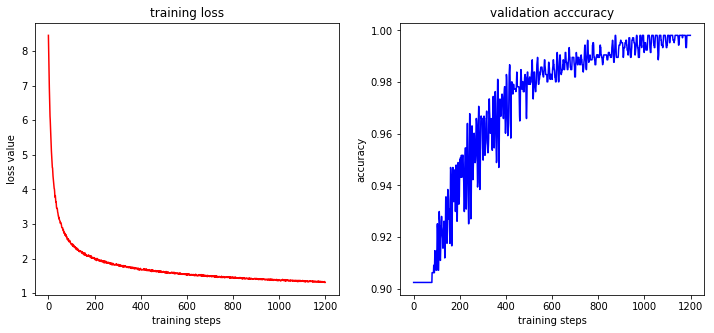

In [19]:

print("The accuracy of MLP on the validation is: \t\t", valid_acc_new[-1])

fig = plt.figure(figsize = (12, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(train_loss_new, 'r')
ax1.set_title("training loss")
ax1.set_xlabel("training steps")
ax1.set_ylabel("loss value")
ax2.plot(valid_acc_new, 'b')
ax2.set_title("validation acccuracy")
ax2.set_xlabel("training steps")
ax2.set_ylabel("accuracy")
plt.show()


Also, the test on the whole test set is conducted. Results are printed out at the end.

Brief conclusion would be,
1. The reason why it way outperforms either NCC classifer or original MLP is that, it is complex than the normal image processing skill and it takes only the key feature of the image instead of the image itself. This could make the model quickly learn what it needs to tell two images are showing the same face or not. 
2. Since the new model take the inputs sized $1/3$ of the original image data, it speeds up both the training process and the prediction process.

In [20]:

MLP_acc_same_new, MLP_time_same_new = MLPTestOnBatch(test_images_new, test_same_ind, model_new, batch_size)
print("Accuracy of NCC classifier on the same face data:\t", MLP_acc_same_new, \
      " average prediction time:\t", MLP_time_same_new)
MLP_acc_diff_new, MLP_time_diff_new = MLPTestOnBatch(test_images_new, test_diff_ind, model_new, batch_size)
print("Accuracy of NCC classifier on the different face data:\t", MLP_acc_diff_new, \
      " average prediction time:\t", MLP_time_diff_new)
MLP_acc_all_new, MLP_time_all_new = MLPTestOnBatch(test_images_new, all_test_pairs, model_new, batch_size)
print("Accuracy of NCC classifier on the all data:\t", MLP_acc_all_new, \
      " average prediction time:\t", MLP_time_all_new)


----------------------------- fresh results -------------------------------
Accuracy of NCC classifier on the same face data:	 0.9359130859375  average prediction time:	 0.0667349100112915
----------------------------- fresh results -------------------------------]
Accuracy of NCC classifier on the different face data:	 0.474363312007874  average prediction time:	 0.06606659926767425
----------------------------- fresh results -------------------------------]
Accuracy of NCC classifier on the all data:	 0.5273027753496503  average prediction time:	 0.06685041547655225
